In [1]:
import ario3.simulation.base as sim
import pathlib
import numpy as np
import dash
from dash import dcc
from dash import html
import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output
import pandas as pd

In [2]:
app = dash.Dash(__name__)

In [3]:
# Fully display a dataframe (all lines and columns)
def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)

In [6]:
params_path = pathlib.Path("./ario3/test/mock_data/")
mrio_path = pathlib.Path("./ario3/test/mock_data/mrio.pkl")
model = sim.Simulation(mrio_path, params_path)
ev_file = pathlib.Path('./ario3/test/mock_data/test_events3.json')
model.read_events(ev_file)

In [2]:
model.next_step()

In [3]:
model.events[0].occurence_time

4

In [ ]:
model.loop()

In [32]:
import pandas as pd
def load_files(results_path, indexes, tot_time):
    t = tot_time
    if indexes['fd_cat'] is None:
        indexes['fd_cat'] = np.array(["Final demand"])
    prod = np.memmap(results_path/"iotable_XVA_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    prodmax = np.memmap(results_path/"iotable_X_max_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    overprod = np.memmap(results_path/"overprodvector_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    c_demand = np.memmap(results_path/"classic_demand_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    r_demand = np.memmap(results_path/"rebuild_demand_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    r_prod = np.memmap(results_path/"rebuild_prod_record", mode='r+', dtype='float32',shape=(t,indexes['n_industries']))
    fd_unmet = np.memmap(results_path/"final_demand_unmet_record", mode='r+', dtype='float32',shape=(t,indexes['n_regions']*len(indexes['fd_cat'])))
    stocks = np.memmap(results_path/"stocks_record", mode='r+', dtype='float32',shape=(t*indexes['n_sectors'],indexes['n_industries']))
    
    all_sectors = indexes['sectors']
    all_countries = indexes['regions']
    
    sectors = list(all_sectors)
    countries = list(all_countries)
    steps = [i for i in range(tot_time)]
    
    prod_df = pd.DataFrame(prod, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    prodmax_df = pd.DataFrame(prodmax, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    overprod_df = pd.DataFrame(overprod, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    c_demand_df = pd.DataFrame(c_demand, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    r_demand_df = pd.DataFrame(r_demand, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    r_prod_df = pd.DataFrame(r_prod, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    fd_unmet_df = pd.DataFrame(fd_unmet, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['fd_cat']]))
    stocks_df = pd.DataFrame(stocks, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
    stocks_df.index = pd.MultiIndex.from_product([steps, sectors], names=['step', 'stock of'])
    
    files = {
        "production":prod_df,
        "rebuild_production":r_prod_df,
        "production_max":prodmax_df,
        "demand":c_demand_df,
        "rebuild_demand":r_demand_df,
        "overprod":overprod_df,
        "fdloss":fd_unmet_df,
        "stocks":stocks_df
    }
    #TODO: implement this
    #if os.path.isfile(results_path+scenario+"/stocks.csv"):
    #    files['stocks'] = pd.read_csv(results_path+scenario+"/stocks.csv", skiprows=2, names=pd.MultiIndex.from_product([countries, sectors], names=['regions', 'sectors']))
    #    files['stocks'].index = pd.MultiIndex.from_product([steps, sectors], names=['steps','stock of'])
    #    files['stocks'].name = "Stocks - "
    #if os.path.isfile(results_path+scenario+"/limiting_stocks.csv"):
    #    files['limiting'] = pd.read_csv(results_path+scenario+"/limiting_stocks.csv", skiprows=2, names=pd.MultiIndex.from_product([countries, sectors], names=['regions', 'sectors']))
    #    files['limiting'].index = pd.MultiIndex.from_product([steps, sectors], names=['steps','stock of'])
    #    files['limiting'].name = "Limiting stocks - "
        
    files["production"].name="Prod - "
    files["rebuild_production"].name="Rebuild prod - "
    files["production_max"].name="ProdMax - "
    files["demand"].name="\"Classic\" Demand - "
    files["rebuild_demand"].name="Rebuild demand - "
    files["overprod"].name="Overprod - "
    files["fdloss"].name="FD Losses - "
    return files


In [162]:
import json
import pathlib
with pathlib.Path('./ario3/test/mock_data/small/indexes.json').open('r') as f:
    indexes = json.load(f)
files = load_files(pathlib.Path("./ario3/test/mock_data/results/test/"), indexes, 365)

In [8]:
import pycountry
import pandas as pd
import numpy as np
import pymrio as pym
import itertools
import mplcursors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import os

size=32
#size=15
params = {'legend.fontsize': size*0.75,
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def all_c_except(all_c, c):
    try:
        all_c.remove(c)
    except ValueError:
        print(str(c)+" already not in list")
    return(all_c)

def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

# Return country name from eora alpha3 code
def country_n(country):
    if len(country) == 3:
        if country == 'SUD':
            iso3 = 'SDN'
        if country == 'ANT':
            iso3 = 'ATG'
        if country == 'SDS':
            iso3 = 'SSD'
        if country == 'USR':
            return 'USSR (??)'
        else:
            iso3 = country
        return pycountry.countries.get(alpha_3=iso3).name
    elif len(country) == 2:
        if country == 'WA':
            return 'RoW Asia and Pacific'
        if country == 'WL':
            return 'RoW America'
        if country == 'WE':
            return 'RoW Europe'
        if country == 'WF':
            return 'RoW Africa'
        if country == 'WM':
            return 'RoW Middle-East'
        else:
            return pycountry.countries.get(alpha_2=country).name

# Fully display a dataframe (all lines and columns)
def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)

def variable_n(variable):
    r = ""
    if variable == "Production":
        r = "Changement de la capacité de production (en VA, avec contrainte d'inventaire)"
    if variable == "Production cap":
        r = "Changement de la capacité de production (sans contrainte d'inventaire)"
    if variable == "Demand":
        r = "Changement de la demande"
    if variable == "Final demand":
        r = "Perte de consommation (demande finale)"
    return r
        
# Plot selected data from selected dfs (works for total demand, production, production_max, overprod, and final demand)
# Can plot data from multiple dfs, countries, selected sectors
# Possibility to start from t!=0 (with start = t) and to stop at t=steps
# Either plot as pct change from initial value or absolute values (pct=False)

def plot_results(dfs, ax, countries=None, sectors_i=None, steps=None, start=0, pct=False, aggregate_c=False, aggregate_s=False):     
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in labels:
            return labels[int(tick_val)]
        else:
            return ''  
    
    def aggr(df, aggregate_c, aggregate_s):
        if aggregate_c and aggregate_s:
            return df.sum(axis=1)
        elif aggregate_c:
            return df.sum(axis=1, level=1)
        elif aggregate_s:
            return df.sum(axis=1, level=0)
        else:
            return df
    marks = ['1', 'x', 'o', 'd']
    i = 0
    total_t = max(len(df) for df in dfs)
    if steps is not None:
        total_t = min(total_t, steps)
    # return(intensity, country, scheme, variable)
    #df_caracs = [df_type_sel(df) for df in dfs]
    #print(df_caracs)
    #try:
    #    intensities = ["{:.1f}".format(intensity_n(c[0])) for c in df_caracs]
    #except ValueError:
    #    intensities = ["nc" for c in df_caracs]
    #imp_countries = [country_n(c[1]) for c in df_caracs]
    #variables = [c[2] for c in df_caracs]
    #print(variables)
    #print(countries)
    #print(imp_countries)
    #print(intensities)
    if aggregate_c :
        assert(len(countries)>1)
    if aggregate_s :
        assert(sectors_i is None or len(sectors_i)>1)
    #if len(countries) < 5:
    #    title = ", ".join(variables)+" in "+", ".join(countries)+" after a flood in "+imp_countries[0]+" (intensity: "+", ".join(intensities)+"% PIB)"
    #else:
    #    title = ", ".join(variables)+" in multiple countries after a flood in "+imp_countries[0]+" (intensity: "+", ".join(intensities)+"% PIB)"
    #if aggregate_c and aggregate_s :
    #    subtitle = "aggregated for selected countries and sectors"
    #elif aggregate_c:
    #    subtitle = "aggregated for selected countries"
    #elif aggregate_s:
    #    subtitle = "aggregated for selected sectors"
    #else:
    #    subtitle = ""
    for df in dfs:
        #intensity, country, variable = df_type_sel(df)
        #var = variable #df.name.split("_")[2]
        if sectors_i is None:
            sectors = np.unique(df.columns.get_level_values(1))
        else:
            sectors = sectors_i
        if countries is not None:
            idx = pd.IndexSlice[countries,sectors]
        else:
            idx = pd.IndexSlice[:,sectors]
        mark = marks[i]
        if steps is not None:
            if pct:
                tmp = aggr(df.loc[pd.IndexSlice[start:steps],idx], aggregate_c, aggregate_s).pct_change().fillna(0).add(1).cumprod().sub(1)
                tmp.plot(ax=ax, grid=True, marker=mark)
            else:
                aggr(df.loc[pd.IndexSlice[start:steps],idx], aggregate_c, aggregate_s).plot(ax=ax, grid=True, marker=mark)
        else:
            if pct:
                tmp = aggr(df.loc[pd.IndexSlice[start:],idx], aggregate_c, aggregate_s).pct_change().fillna(0).add(1).cumprod().sub(1)
                tmp.plot(ax=ax, grid=True, marker=mark)
            else:
                aggr(df.loc[pd.IndexSlice[start:],idx], aggregate_c, aggregate_s).plot(ax=ax, grid=True, marker=mark)
        i=i+1
    #handles, labels = ax.get_legend_handles_labels()
    #names = [name for name, _ in dfs.items()]
    #labels_2 = itertools.product(names, np.unique(labels))
    #ax.legend(handles, [name+" - "+label for name, label in labels_2])
    labels = np.arange(0, total_t, 1)
    if pct:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        #ax.set_ylabel(variable+' % change')  # Add a y-label to the axes.
        ax.set_ylabel(' % change')  # Add a y-label to the axes.
    else:
        #ax.set_ylabel(variable+' (\'M$2016)')  # Add a y-label to the axes.
        ax.set_ylabel(' (\'M$2016)')  # Add a y-label to the axes.
    ax.set_xlabel('Time (days)')  # Add an x-label to the axes.
    major_ticks = np.arange(0, total_t, 28)
    minor_ticks = np.arange(0, total_t, 7)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    #legend(ax,y0=0.8, direction="h", borderaxespad=0.1)
    ax.xaxis.set_major_formatter(format_fn)
    #plt.title(title+'\n'+subtitle)
    return ax

In [ ]:
   # files = {
   #     "production":prod_df,
   #     "rebuild_production":r_prod_df,
   #     "production_max":prodmax_df,
   #     "demand":c_demand_df,
   #     "rebuild_demand":r_demand_df,
   #     "overprod":overprod_df,
   #     "fdloss":fd_unmet_df,
   # }

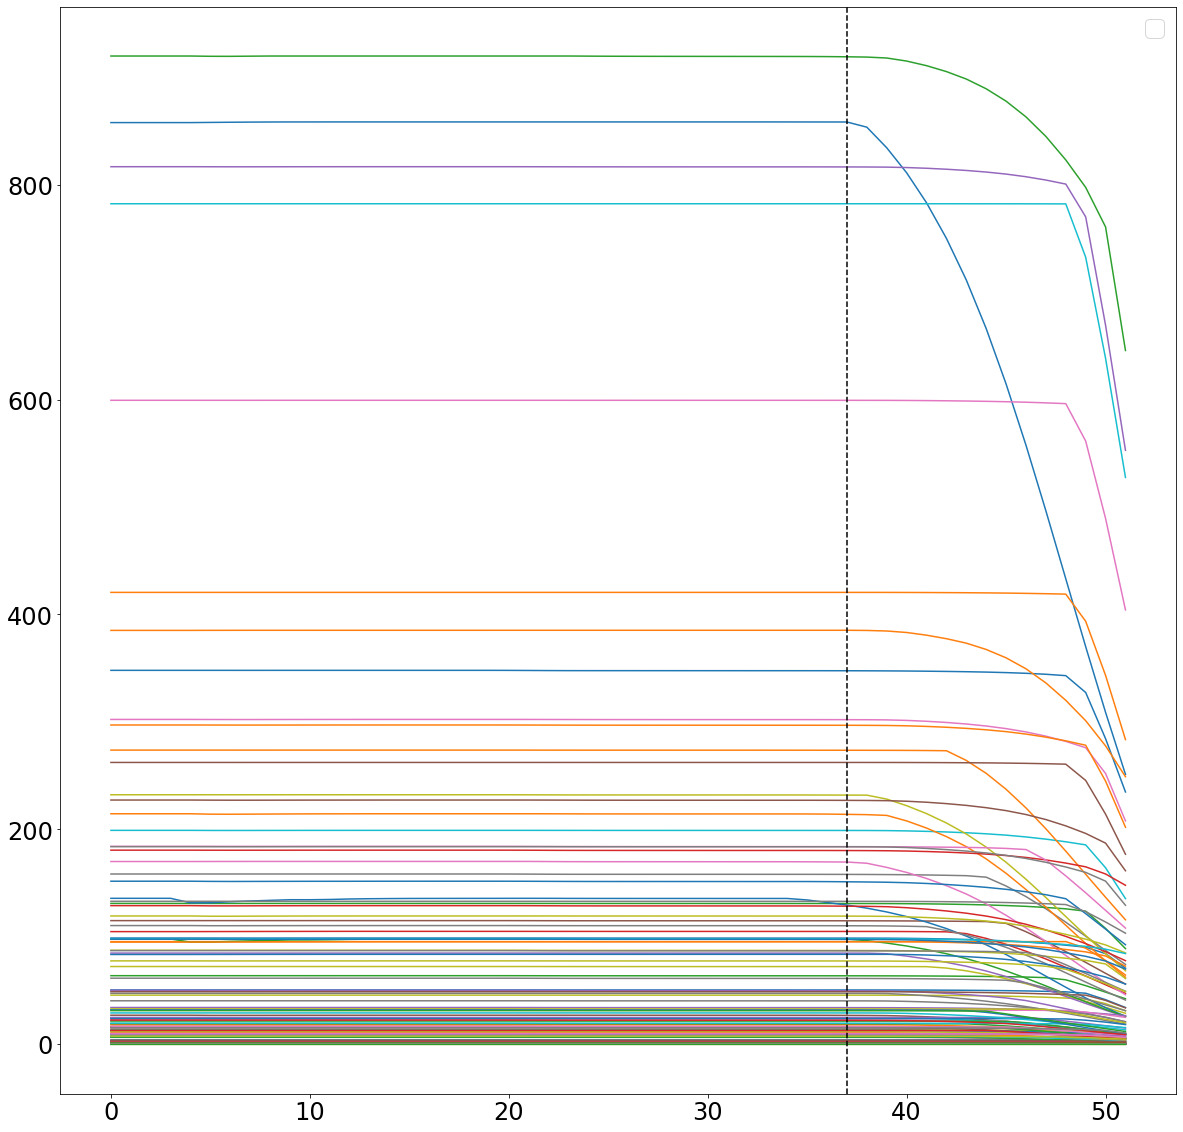

In [89]:
fig,ax = plt.subplots(figsize=(20,20))
files["production"]['FR'].loc[0:51,:].plot(ax=ax)
ax.legend("")
ax.axvline(x=37, linestyle='--', color='k')

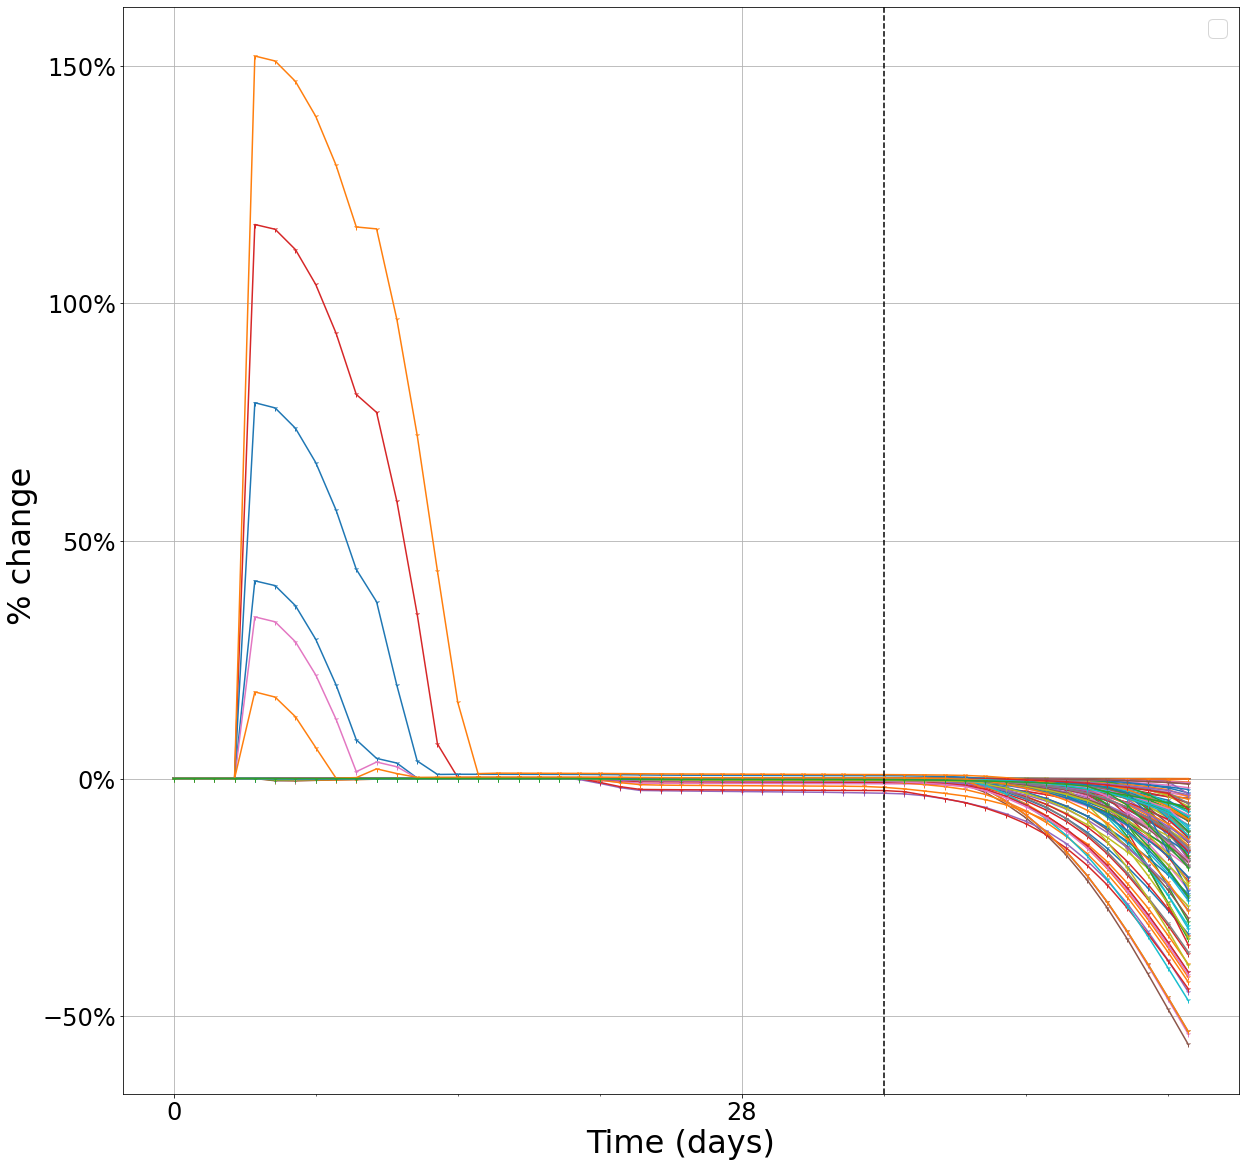

In [100]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,20))

#prod_df.loc[:,('DE',"Manufacture of office machinery and computers (30)")].plot(ax=ax)
#c_demand_df.loc[:,('DE',"Manufacture of office machinery and computers (30)")].plot(ax=ax)
#r_prod_df.loc[0:45,('FR',"Manufacture of office machinery and computers (30)")].plot(ax=ax)
#r_demand_df.loc[0:45,('FR',"Manufacture of office machinery and computers (30)")].plot(ax=ax)

plot_results([files["demand"]+files["rebuild_demand"]], countries=['FR'],ax=ax,steps=50, pct=True)
ax.axvline(x=35, linestyle='--', color='k')
#display_f(files['rebuild_production']['DE'])
ax.legend("")

In [ ]:
results_path = pathlib.Path("./ario3/test/mock_data/results/test_multi_ev/")
stocks = np.memmap(results_path/"stocks_record", mode='r+', dtype='float32',shape=(365*indexes['n_sectors'],indexes['n_industries']))
stocks_df = pd.DataFrame(stocks, columns=pd.MultiIndex.from_product([indexes['regions'], indexes['sectors']]))
steps = range(365)
stocks_df.index = pd.MultiIndex.from_product([steps, indexes['sectors']], names=['steps','stock of'])
stocks_df

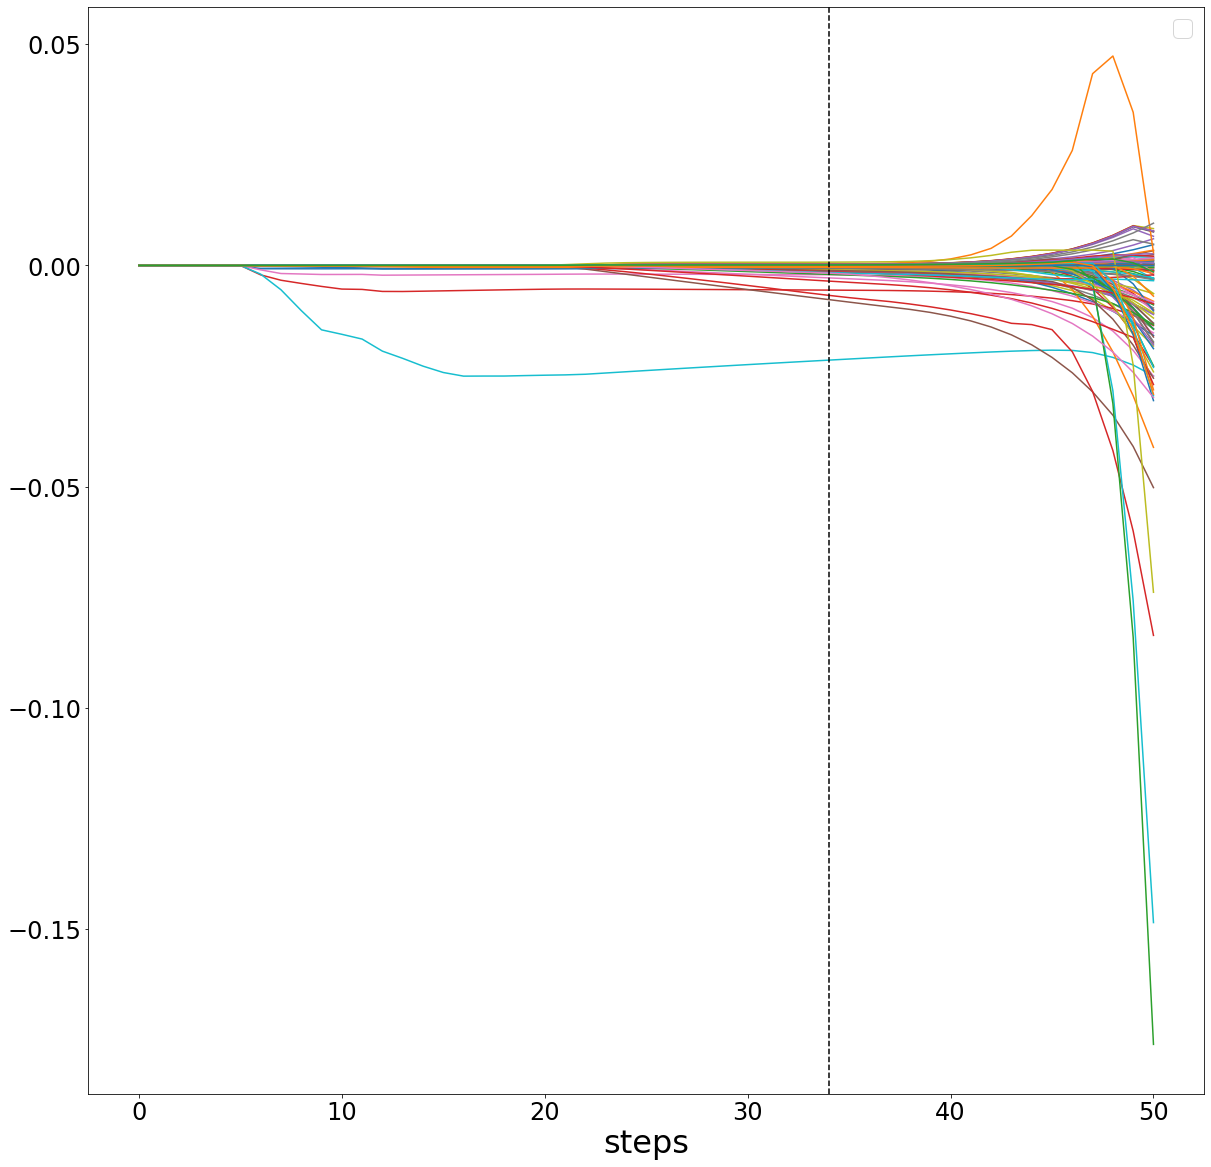

In [98]:
fig,ax = plt.subplots(figsize=(20,20))
stocks_df.loc[:,'DE'].sum(axis=1).unstack().pct_change().fillna(0).add(1).cumprod().sub(1).loc[0:50,:].plot(ax=ax)
ax.legend("")
ax.axvline(x=34, linestyle='--', color='k')

In [86]:
def style_negative(v, props=''):
    return props if v < 0 else None

df2 = files['production']['FR'].pct_change().fillna(0).add(1).cumprod().sub(1).loc[30:40,:]

s2 = df2.style.applymap(style_negative, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 0.03) and (v > -0.03) else None)
s2


,Activities auxiliary to financial intermediation (67),Activities of membership organisation n.e.c. (91),Air transport (62),Aluminium production,Animal products nec,Casting of metals,Cattle farming,Chemicals nec,"Collection, purification and distribution of water (41)",Computer and related activities (72),Construction (45),Copper production,Cultivation of cereal grains nec,Cultivation of crops nec,Cultivation of oil seeds,Cultivation of paddy rice,Cultivation of plant-based fibers,"Cultivation of sugar cane, sugar beet","Cultivation of vegetables, fruit, nuts",Cultivation of wheat,Distribution and trade of electricity,Education (80),Extra-territorial organizations and bodies,"Extraction of crude petroleum and services related to crude oil extraction, excluding surveying","Extraction of natural gas and services related to natural gas extraction, excluding surveying","Extraction, liquefaction, and regasification of other petroleum and gaseous materials","Financial intermediation, except insurance and pension funding (65)","Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)","Forestry, logging and related service activities (02)",Health and social work (85),Hotels and restaurants (55),Inland water transport,"Insurance and pension funding, except compulsory social security (66)","Lead, zinc and tin production",Manufacture of basic iron and steel and of ferro-alloys and first products thereof,Manufacture of beverages,"Manufacture of bricks, tiles and construction products, in baked clay","Manufacture of cement, lime and plaster",Manufacture of ceramic goods,Manufacture of coke oven products,Manufacture of electrical machinery and apparatus n.e.c. (31),"Manufacture of fabricated metal products, except machinery and equipment (28)",Manufacture of fish products,Manufacture of furniture; manufacturing n.e.c. (36),Manufacture of gas; distribution of gaseous fuels through mains,Manufacture of glass and glass products,Manufacture of machinery and equipment n.e.c. (29),"Manufacture of medical, precision and optical instruments, watches and clocks (33)","Manufacture of motor vehicles, trailers and semi-trailers (34)",Manufacture of office machinery and computers (30),Manufacture of other non-metallic mineral products n.e.c.,Manufacture of other transport equipment (35),"Manufacture of radio, television and communication equipment and apparatus (32)",Manufacture of rubber and plastic products (25),Manufacture of textiles (17),Manufacture of tobacco products (16),Manufacture of wearing apparel; dressing and dyeing of fur (18),"Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)","Manure treatment (biogas), storage and land application","Manure treatment (conventional), storage and land application",Meat animals nec,Mining of aluminium ores and concentrates,"Mining of chemical and fertilizer minerals, production of salt, other mining and quarrying n.e.c.",Mining of coal and lignite; extraction of peat (10),Mining of copper ores and concentrates,Mining of iron ores,"Mining of lead, zinc and tin ores and concentrates",Mining of nickel ores and concentrates,Mining of other non-ferrous metal ores and concentrates,Mining of precious metal ores and concentrates,Mining of uranium and thorium ores (12),N-fertiliser,Other business activities (74),Other land transport,Other non-ferrous metal production,Other service activities (93),P- and other fertiliser,Paper,Petroleum Refinery,Pigs farming,"Plastics, basic",Post and telecommunications (64),Poultry farming,Precious metals production,Private households with employed persons (95),Processed rice,Processing of Food products nec,Processing of dairy products,Processing of meat cattle,Processing of meat pigs,Processing of meat poultry,Processing of nuclear fuel,Processing vegetable oils and fats,Production of electricity by Geothermal,Production of electricity by biomass and waste

In [146]:
files['production'].set_index('step').pct_change().fillna(0).add(1).cumprod().sub(1).melt(ignore_index=False)

,variable_0,variable_1,value
step,,,
0,reg1,construction,0.000000
1,reg1,construction,0.000000
2,reg1,construction,0.000000
3,reg1,construction,0.000000
4,reg1,construction,-0.927267
...,...,...,...
360,reg6,transport,-1.000000
361,reg6,transport,-1.000000
362,reg6,transport,-1.000000


In [18]:
df = files['production']['FR']
fig = px.line(df, x=df.index, y=df.columns)
fig.layout.update(showlegend=False)
fig.show()

KeyError: 'FR'

In [195]:
import json
import pathlib
with pathlib.Path('./ario3/test/mock_data/small/indexes.json').open('r') as f:
    indexes = json.load(f)
    
files = load_files(pathlib.Path("./ario3/test/mock_data/results/test/"), indexes, 365)
files['demand']['step']=files['demand'].index
files['rebuild_production']['step']=files['rebuild_production'].index
files['production_max']['step']=files['production_max'].index
files['rebuild_demand']['step']=files['rebuild_demand'].index
files['overprod']['step']=files['overprod'].index

files['production']['step']=files['production'].index
df = files['production'].set_index('step').pct_change().fillna(0).add(1).cumprod().sub(1).melt(ignore_index=False)
df=df.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'production'})

df2 = files['demand'].set_index('step').pct_change().fillna(0).add(1).cumprod().sub(1).melt(ignore_index=False)
df2=df2.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'demand'})
df['demand']=df2['demand']

df2 = files['rebuild_production'].set_index('step').melt(ignore_index=False)
df2=df2.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'rebuild_production'})
df['rebuild_production']=df2['rebuild_production']

df2 = files['production_max'].set_index('step').pct_change().fillna(0).add(1).cumprod().sub(1).melt(ignore_index=False)
df2=df2.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'production_max'})
df['production_max']=df2['production_max']

df2 = files['rebuild_demand'].set_index('step').melt(ignore_index=False)
df2=df2.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'rebuild_demand'})
df['rebuild_demand']=df2['rebuild_demand']

df2 = files['overprod'].set_index('step').melt(ignore_index=False)
df2=df2.rename(columns={'variable_0':'region','variable_1':'sector', 'value':'overprod'})
df['overprod']=df2['overprod']

df = df.reset_index().melt(id_vars=['region', 'sector', 'step'])

df_stocks = (files['stocks'].unstack(level=1).pct_change().fillna(0).add(1).cumprod().sub(1)).melt(ignore_index=False).rename(columns={'variable_0':'region','variable_1':'sector', 'variable_2':'stock of'}).reset_index()

In [196]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Load Data
app = JupyterDash(__name__)


app.layout = html.Div(children = [
    html.Div(style={'display': 'grid', 'grid-template-columns': '1fr 1fr', 'grid-column-gap' : '20px'}, children=[
        html.Div(children=[
            html.H1("Main variables evolution"),
            html.Div(style={'width':'auto'}, children=[
                html.Label("Regions selected"),
                dcc.Dropdown(
                    id='region-dropdown',
                    value=[df.region.unique()[0]], options=[
                        {'label': c, 'value': c}
            for c in df.region.unique()
                    ],
                    multi=True
                ),
                html.Label("Sectors selected"),
                dcc.Dropdown(
                    id='sector-dropdown',
                    value=[df.sector.unique()[0]], options=[
                        {'label': c, 'value': c}
            for c in df.sector.unique()
                    ],
                    multi=True
                ),
                html.Label("Variables selected"),
                dcc.Checklist(
                    id='variable-checklist',
                    options=[
                        {'label': 'Production', 'value': 'production'},
                        {'label': 'Rebuild production', 'value': 'rebuild_production'},
                        {'label': 'Production Cap', 'value': 'production_max'},
                        {'label': 'Demand', 'value': 'demand'},
                        {'label': 'Rebuild demand', 'value': 'rebuild_demand'},
                        {'label': 'Overproduction', 'value': 'overprod'}
                    ],
                    value=['production']
                )
            ]),
        ]),
        html.Div(
            children=[
                html.H1("Stocks evolution"),
                html.Div(style={'width':'auto'}, children=[
                    html.Label("Sector selected"),
                    dcc.Dropdown(
                        id='stock-sector-dropdown',
                        value=df.sector.unique()[0], options=[
                            {'label': c, 'value': c}
            for c in df.sector.unique()
                        ],
                        multi=False
                    ),
                    html.Div(style={'width':'auto'}),
                    html.Label("Stocks of :"),
                    dcc.Dropdown(
                        id='stock-dropdown',
                        value=[df.sector.unique()[0]], options=[
                            {'label': c, 'value': c}
            for c in df.sector.unique()
                        ],
                        multi=True
                    )]),
                
            ]),# Define callback to update graph
        html.Div([dcc.Graph(id='graph-1')]),
        html.Div([dcc.Graph(id='graph-2')]),
    ]),
    html.Label("Steps"),
    dcc.RangeSlider(
        min=df.step.min(),
        max=df.step.max(),
        value=[df.step.min(),df.step.max()],
        marks={str(step): str(step) for step in df['step'].unique() if step % 10 == 0},
        tooltip={"placement": "bottom", "always_visible": True},
        allowCross=False,
        id='year-selection'
    ),
    html.Div(children=[
            html.H1("Usefull second graph"),
            html.Div(style={'width':'auto'}, children=[
                html.Label("Regions selected"),
                dcc.Dropdown(
                    id='region-dropdown-2',
                    value=[df.region.unique()[0]], options=[
                        {'label': c, 'value': c}
            for c in df.region.unique()
                    ],
                    multi=True
                ),
                html.Label("Sectors selected"),
                dcc.Dropdown(
                    id='sector-dropdown-2',
                    value=[df.sector.unique()[0]], options=[
                        {'label': c, 'value': c}
            for c in df.sector.unique()
                    ],
                    multi=True
                ),
                html.Label("Variables selected"),
                dcc.Checklist(
                    id='variable-checklist-2',
                    options=[
                        {'label': 'Production', 'value': 'production'},
                        {'label': 'Rebuild production', 'value': 'rebuild_production'},
                        {'label': 'Production Cap', 'value': 'production_max'},
                        {'label': 'Demand', 'value': 'demand'},
                        {'label': 'Rebuild demand', 'value': 'rebuild_demand'},
                        {'label': 'Overproduction', 'value': 'overprod'}
                    ],
                    value=['production']
                )
            ]),
            html.Div([dcc.Graph(id='graph-3')])
    ])
])

@app.callback(
    Output('graph-1', 'figure'),
    Input('region-dropdown', 'value'),
    Input('sector-dropdown', 'value'),
    Input('variable-checklist', 'value'),
    Input('year-selection', 'value')
)
def update_graph1(region_selection, sector_selection, variable_selection, year_selection):
    #fig = make_subplots(specs=[[{"secondary_y": True}]])
    dff = df[df.step.between(year_selection[0],year_selection[1])]
    dff = dff[dff.region.isin(region_selection)]
    dff = dff[dff.sector.isin(sector_selection)]
    dff = dff[dff.variable.isin(variable_selection)]
    fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff.sector, line_dash=dff.variable)
    #fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    return fig

@app.callback(
    Output('graph-3', 'figure'),
    Input('region-dropdown-2', 'value'),
    Input('sector-dropdown-2', 'value'),
    Input('variable-checklist-2', 'value'),
    Input('year-selection', 'value')
)
def update_graph3(region_selection, sector_selection, variable_selection, year_selection):
    #fig = make_subplots(specs=[[{"secondary_y": True}]])
    dff = df[df.step.between(year_selection[0],year_selection[1])]
    dff = dff[dff.region.isin(region_selection)]
    dff = dff[dff.sector.isin(sector_selection)]
    dff = dff[dff.variable.isin(variable_selection)]
    fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff.sector, line_dash=dff.variable)
    #fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    return fig
    
@app.callback(
    Output('graph-2', 'figure'),
    Input('region-dropdown', 'value'),
    Input('stock-sector-dropdown', 'value'),
    Input('year-selection', 'value'),
    Input('stock-dropdown', 'value')
)
def update_graph2(region_selection, sector, year_selection, stocks_selection):
    #fig = make_subplots(specs=[[{"secondary_y": True}]])
    dff = df_stocks
    dff = dff[dff.sector==sector]
    dff = dff[dff.step.between(year_selection[0],year_selection[1])]
    dff = dff[dff.region.isin(region_selection)]
    dff = dff[dff["stock of"].isin(stocks_selection)]
    fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff['stock of'])
    #fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    return fig


app.run_server(mode='external')


Dash app running on http://127.0.0.1:8050/


In [84]:
idx = pd.IndexSlice


,step,stock of,region,sector,value
0,0,construction,reg1,construction,14335.731445
1,0,electricity,reg1,construction,37.762249
2,0,food,reg1,construction,71.180862
3,0,manufactoring,reg1,construction,19307.542969
4,0,mining,reg1,construction,692.289246
...,...,...,...,...,...
140155,364,manufactoring,reg6,transport,8998.750977
140156,364,mining,reg6,transport,127.439323
140157,364,other,reg6,transport,5826.889160
140158,364,trade,reg6,transport,3945.870361


In [62]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Load Data
app = JupyterDash(__name__)


app.layout = html.Div(children=[
    html.Div([
        html.H1("JupyterDash Demo"),
        html.Label("regions"),
        dcc.Dropdown(
            id='region-dropdown',
            value=[df.region.unique()[0]], options=[
                {'label': c, 'value': c}
            for c in df.region.unique()
            ],
            multi=True
        ),
        html.Label("sectors"),
        dcc.Dropdown(
            id='sector-dropdown',
            value=[df.sector.unique()[0]], options=[
                {'label': c, 'value': c}
            for c in df.sector.unique()
            ],
            multi=True
        ),
    ])
])
@app.callback(
    Output('graph-1', 'figure'),
    Input('region-dropdown', 'value'),
    Input('sector-dropdown', 'value'),
    Input('variable-checklist', 'value'),
    Input('year-selection', 'value')
)
def update_graph1(region_selection, sector_selection, variable_selection, year_selection):
    #fig = make_subplots(specs=[[{"secondary_y": True}]])
    dff = df[df.step.between(year_selection[0],year_selection[1])]
    dff = dff[dff.region.isin(region_selection)]
    dff = dff[dff.sector.isin(sector_selection)]
    dff = dff[dff.variable.isin(variable_selection)]
    fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff.sector, line_dash=dff.variable)
    #fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    return fig

@app.callback(
    Output('graph-2', 'figure'),
    Input('region-dropdown', 'value'),
    Input('stock-sector-dropdown', 'value'),
    Input('year-selection', 'value'),
    Input('stock-dropdown', 'value')
)
def update_graph2(region_selection, sector, year_selection, stocks_selection):
    #fig = make_subplots(specs=[[{"secondary_y": True}]])
    dff = df_stocks
    dff = dff[dff.sector==sector]
    dff = dff[dff.step.between(year_selection[0],year_selection[1])]
    dff = dff[dff.region.isin(region_selection)]
    dff = dff[dff["stock of"].isin(stocks_selection)]
    fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff['stock of'])
    #fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    return fig


app.run_server(mode='external')


,region,sector,step,variable,value
731825,FR,Construction (45),0,production,857.634033
731826,FR,Construction (45),1,production,857.634705
731827,FR,Construction (45),2,production,857.634766
731828,FR,Construction (45),3,production,857.634827
731829,FR,Construction (45),4,production,857.634949
...,...,...,...,...,...
3110890,FR,Construction (45),360,demand,0.000000
3110891,FR,Construction (45),361,demand,0.000000
3110892,FR,Construction (45),362,demand,0.000000
3110893,FR,Construction (45),363,demand,0.000000
